
📈 Round 1
🧠 Market Sentiment: Neutral

 Simulating Market Round...

 Market Event: None
TechCorp [Bull] rolls 3.0, changes by 300.00
EcoPower [Bear] rolls 6.0, changes by 288.00
GovBond 10Y [Neutral] rolls 6.0, changes by -190.00
Gold Futures [Bull] rolls 3.0, changes by 153.00
BitNova [Bear] rolls 6.0, changes by 528.00

 Diversification Bonuses:

 Prices After Round:
TechCorp: $400.00
EcoPower: $378.00
GovBond 10Y: $1.00
Gold Futures: $238.00
BitNova: $638.00

📈 Round 2
🧠 Market Sentiment: Neutral

 Simulating Market Round...

 Market Event: Inflation Spike
TechCorp [Bull] rolls 2.0, changes by -180.00
EcoPower [Bull] rolls 3.0, changes by 194.40
GovBond 10Y [Bear] rolls 6.0, changes by 136.80
Gold Futures [Neutral] rolls 6.0, changes by -318.75
BitNova [Bull] rolls 4.0, changes by -475.20
❌ MarketMaker not enough TechCorp to sell
❌ MarketMaker not enough TechCorp to sell
❌ MarketMaker not enough TechCorp to sell

 Diversification Bonuses:

 Prices After Round:
TechCorp: $220.00
Eco

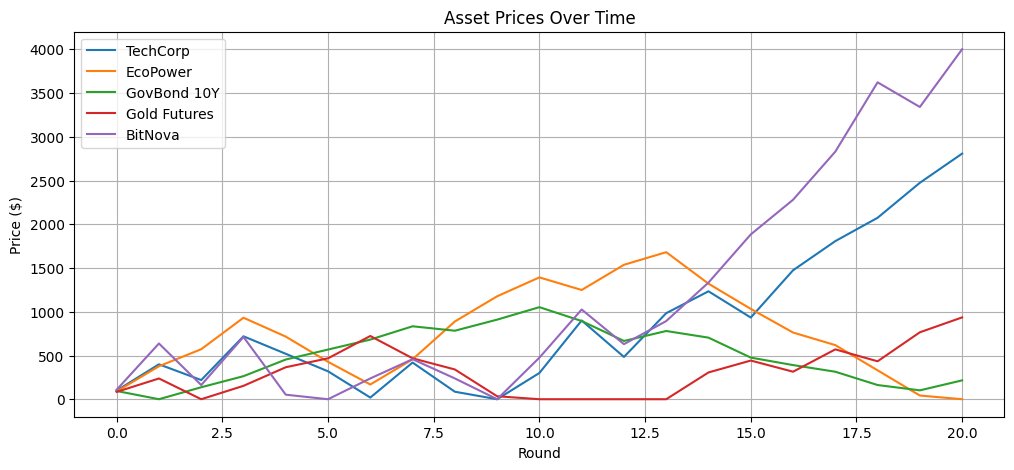

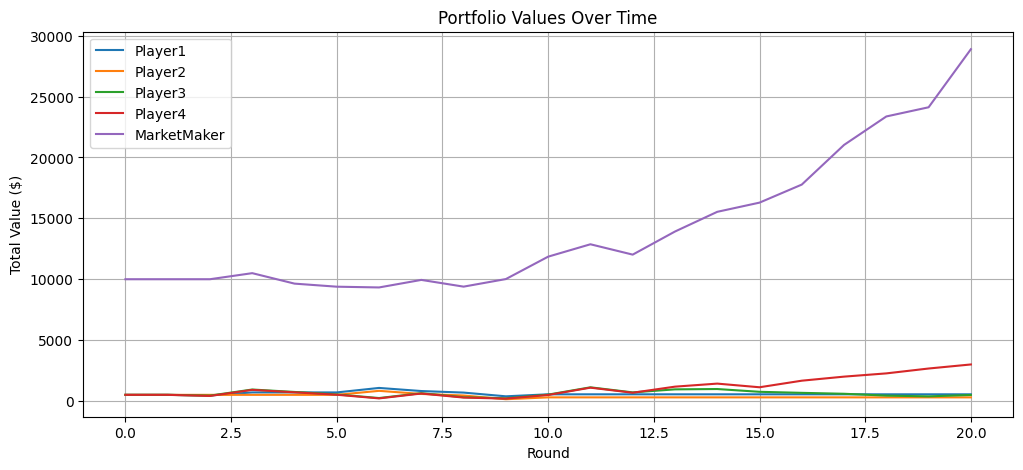

In [2]:
import sys
sys.path.append('../src')

from asset_classes import StockCard, BondCard, CommodityCard, CryptoCard
from order_book import OrderBook, Order
from market_simulation import run_simulation_round
from portfolio import Portfolio
from sentiment import roll_sentiment
import matplotlib.pyplot as plt
import random
import csv

# 📈 Bot with valuation + momentum + sentiment-following logic
class SmartPlayerBot:
    def __init__(self, player_id):
        self.player_id = player_id
        self.last_prices = {}

    def decide_trades(self, portfolio, assets, global_sentiment):
        orders = []
        for asset in assets:
            price = asset.current_price
            base = asset.base_price
            qty = random.randint(1, 2)
            prev_price = self.last_prices.get(asset.name, price)

            momentum = price > prev_price  # price went up
            undervalued = price < base * 0.9
            overvalued = price > base * 1.1
            bullish = global_sentiment == "Bull"

            # Buy logic: undervalued OR price gaining momentum OR bullish sentiment
            if (undervalued or momentum or bullish) and portfolio.cash >= price * qty:
                orders.append(Order(self.player_id, asset.name, price, qty, is_buy=True))

            # Sell logic: overvalued OR price losing momentum OR bearish sentiment
            bearish = global_sentiment == "Bear"
            if (overvalued or not momentum or bearish) and portfolio.holdings.get(asset.name, 0) >= qty:
                orders.append(Order(self.player_id, asset.name, price, qty, is_buy=False))

            self.last_prices[asset.name] = price
        return orders

def declare_winner(portfolios, assets):
    final_prices = {a.name: a.current_price for a in assets}
    values = {pid: pf.get_total_value(final_prices) for pid, pf in portfolios.items()}
    winner = max(values, key=values.get)
    print(f"\n🏆 Winner: {winner} with ${values[winner]:.2f}!")
    return winner, values

def log_to_csv(round_num, assets, portfolios, filename="market_log.csv"):
    with open(filename, mode='a', newline='') as f:
        writer = csv.writer(f)
        for asset in assets:
            writer.writerow(["Round", round_num, "Asset", asset.name, "Price", asset.current_price])
        for pid, pf in portfolios.items():
            total_val = pf.get_total_value({a.name: a.current_price for a in assets})
            writer.writerow(["Round", round_num, "Player", pid, "Value", total_val, "Cash", pf.cash])

assets = [
    StockCard("TechCorp", base_price=100, volatility=5, sector="Technology"),
    StockCard("EcoPower", base_price=90, volatility=4, sector="Energy"),
    BondCard("GovBond 10Y", base_price=95, volatility=2, duration=10, yield_percent=1.5),
    CommodityCard("Gold Futures", base_price=85, volatility=3, reacts_to="Recession"),
    CryptoCard("BitNova", base_price=110, volatility=6)
]

orderbook = OrderBook()
players = [f"Player{i}" for i in range(1, 5)]
portfolios = {pid: Portfolio(pid, initial_cash=500) for pid in players}
portfolios["MarketMaker"] = Portfolio("MarketMaker", initial_cash=9999)

price_history = {asset.name: [asset.current_price] for asset in assets}
portfolio_value_history = {pid: [pf.get_total_value({a.name: a.current_price for a in assets})] for pid, pf in portfolios.items()}

from sentiment import roll_sentiment

bots = {pid: SmartPlayerBot(pid) for pid in players}

for round_num in range(20):
    print(f"\n📈 Round {round_num + 1}")
    sentiment = roll_sentiment()
    print(f"🧠 Market Sentiment: {sentiment}")

    for pid in players:
        bot = bots[pid]
        orders = bot.decide_trades(portfolios[pid], assets, sentiment)
        for order in orders:
            orderbook.place_order(order)

    run_simulation_round(assets, orderbook, portfolios)

    for asset in assets:
        price_history[asset.name].append(asset.current_price)
    for pid, pf in portfolios.items():
        portfolio_value_history[pid].append(pf.get_total_value({a.name: a.current_price for a in assets}))

    log_to_csv(round_num + 1, assets, portfolios)

declare_winner(portfolios, assets)

plt.figure(figsize=(12, 5))
for name, history in price_history.items():
    plt.plot(history, label=name)
plt.title("Asset Prices Over Time")
plt.xlabel("Round")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
for pid, history in portfolio_value_history.items():
    plt.plot(history, label=pid)
plt.title("Portfolio Values Over Time")
plt.xlabel("Round")
plt.ylabel("Total Value ($)")
plt.legend()
plt.grid(True)
plt.show()
